In [1]:
import uproot
import glob
import pandas as pd
from tqdm import tqdm

In [2]:
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt

In [3]:
username = "yian"
import getpass
import os
if os.system('klist | grep Default | grep ' + username + '@CERN.CH'):
    os.system('echo %s' % getpass.getpass() + " | kinit " + username)

klist: No credentials cache found (filename: /tmp/krb5cc_110046_23088)


········
Password for yian@CERN.CH: 


kinit: Password incorrect while getting initial credentials


In [4]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import xgboost as xgb

def train_bdt(df,features,tag,xgboost_params,n_boost_rounds = 10):
     
    df_a=df.copy(deep = True)
    index_neg=df.query('scalef<0').index
    df_a=df_a.drop(index_neg)
    
    X=df_a[features]
    Y=df_a['isSignal']
    #random_state is the seed used by the random number generator, 
    #random_state=42 make others get the same data spliting in different executions.
    # shuffle make the bkg and signal mix randomly.
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, 
                                                        random_state=42,shuffle=True)
    
    idx_train = X_train.index
    idx_test = X_test.index

    dmatrix_train = xgb.DMatrix(X_train.copy(), label=np.copy(y_train),weight=df_a.loc[idx_train,'scalef'])
    dmatrix_test  = xgb.DMatrix(X_test.copy(), label=np.copy(y_test ),weight=df_a.loc[idx_test,'scalef'])

    #n_pos = np.sum(y_train == 1)
    #n_neg = np.sum(y_train == 0)

    n_pos = np.sum(df_a.loc[df_a.loc[idx_train].query('isSignal==1').index,'scalef'])
    n_neg = np.sum(df_a.loc[df_a.loc[idx_train].query('isSignal==0').index,'scalef'])

    print(n_pos,n_neg)
    #xgboost_params["scale_pos_weight"] = 1.
    xgboost_params["scale_pos_weight"] = 1. * n_neg / n_pos

    print('start the training') 
    evals_result={}
    model = xgb.train(xgboost_params,
                      dmatrix_train,
                      num_boost_round=n_boost_rounds,
                      evals= [(dmatrix_train, 'train'),
                              (dmatrix_test, 'test')],
                      evals_result=evals_result,
                      early_stopping_rounds=10,
                      verbose_eval=True)

    best_iteration = model.best_iteration + 1
    if best_iteration < n_boost_rounds:
        print("early stopping after {0} boosting rounds".format(best_iteration))
    print("")
    
    model.save_model("./ajj_bdt_train_"+tag+".json")

    df_a.loc[idx_train, "score_"+tag] = model.predict(dmatrix_train)
    df_a.loc[idx_test, "score_"+tag] = model.predict(dmatrix_test)

    df_a.loc[idx_train, "test"] = False
    df_a.loc[idx_test, "test"] = True
    
    return model,df_a,evals_result

In [5]:
import sklearn.metrics as m
from sklearn.metrics import roc_curve, auc

def get_roc(df_a,score_column):
    fpr, tpr, thresholds = roc_curve(df_a['isSignal'], df_a[score_column])
    roc_auc = auc(fpr, tpr)
 
    return fpr, tpr,roc_auc

In [6]:
year="18"
root_sig = glob.glob("/eos/user/y/yian/AJJ_analysis/add_weight/chain_combine/cutjet-EWAjj*"+year+".root")
root_bkg = glob.glob("/eos/user/y/yian/AJJ_analysis/add_weight/chain_combine/cutjet-GJets1*0ToInf*"+year+".root")

In [7]:
print(root_bkg,root_sig)

['/eos/user/y/yian/AJJ_analysis/add_weight/chain_combine/cutjet-GJets100ToInfLO_18.root', '/eos/user/y/yian/AJJ_analysis/add_weight/chain_combine/cutjet-GJets150ToInf_18.root'] ['/eos/user/y/yian/AJJ_analysis/add_weight/chain_combine/cutjet-EWAjjLO_18.root', '/eos/user/y/yian/AJJ_analysis/add_weight/chain_combine/cutjet-EWAjj_18.root']


In [8]:
branch = uproot.open(root_sig[1]+":Events").keys()
necessary_columns=[]
unnecessary_columns=['vjj_jets','vjj_mus','vjj_eles','vjj_photons','vjj_loosePhotons']
for i in branch:
    if ('vjj_' in i and 'gen' not in i and i not in unnecessary_columns) or ('eff' in i) or ('scalef' in i):        
        necessary_columns.append(i)
print('select necessary branches')

select necessary branches


In [9]:
signal = uproot.lazy(root_sig[1]+':Events')[necessary_columns]
sig=pd.DataFrame(signal[necessary_columns].to_numpy()).query("vjj_isGood==1 & vjj_jj_m>500 & vjj_v_pt>200 & vjj_lead_pt>50 & vjj_sublead_pt>50 & vjj_trig>0")
background=uproot.lazy(root_bkg[1]+':Events')[necessary_columns]
bkg=pd.DataFrame(background[necessary_columns].to_numpy()).query("vjj_isGood==1 & vjj_jj_m>500 & vjj_v_pt>200 & vjj_lead_pt>50 & vjj_sublead_pt>50 & vjj_trig>0")
sig['isSignal']=1
bkg['isSignal']=0

In [10]:
sig['vjj_dphi']=abs(sig['vjj_v_phi']-sig['vjj_jj_phi'])
bkg['vjj_dphi']=abs(bkg['vjj_v_phi']-bkg['vjj_jj_phi'])

In [11]:
bkg['vjj_zepp']=abs(bkg['vjj_v_eta']-(bkg['vjj_lead_eta']+bkg['vjj_sublead_eta'])/2)
sig['vjj_zepp']=abs(sig['vjj_v_eta']-(sig['vjj_lead_eta']+sig['vjj_sublead_eta'])/2)               

In [12]:
sig.loc[sig.query('vjj_dphi>3.14').index,'vjj_dphi']=2*3.14-sig.query('vjj_dphi>3.14')['vjj_dphi']
bkg.loc[bkg.query('vjj_dphi>3.14').index,'vjj_dphi']=2*3.14-bkg.query('vjj_dphi>3.14')['vjj_dphi']

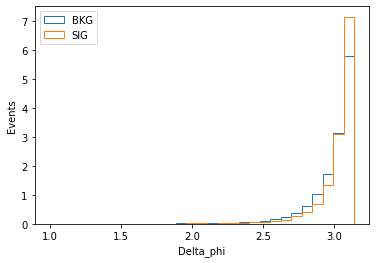

In [13]:
plt.hist(bkg['vjj_dphi'],label = "BKG",histtype="step",bins = np.linspace(1,3.14,30),density=True,weights=bkg['scalef']*bkg['vjj_photon_effWgt']*59.7)
plt.hist(sig['vjj_dphi'], label = "SIG",histtype="step",bins = np.linspace(1,3.14,30),density=True,weights=sig['scalef']*sig['vjj_photon_effWgt']*59.7)
#plt.yscale('symlog')
plt.ylabel('Events')
plt.xlabel('Delta_phi')
plt.legend(loc='upper left')
plt.savefig('dphi_NLO.pdf')

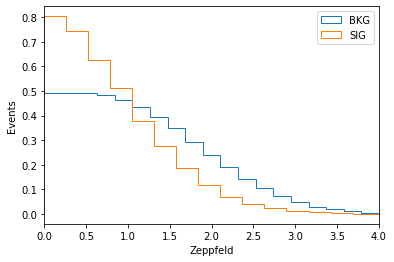

In [14]:
plt.hist(bkg['vjj_zepp'],label = "BKG",histtype="step",bins = np.linspace(0,4,20),density=True,weights=bkg['scalef']*bkg['vjj_photon_effWgt']*59.7)
plt.hist(sig['vjj_zepp'], label = "SIG",histtype="step",bins = np.linspace(0,5,20),density=True,weights=sig['scalef']*sig['vjj_photon_effWgt']*59.7)
#plt.yscale('symlog')
plt.ylabel('Events')
plt.xlabel('Zeppfeld')
plt.legend()
plt.xlim(0,4)
plt.savefig('zepp_NLO.pdf')

In [15]:
features=['vjj_jj_m','vjj_jj_dphi','vjj_jj_pt','vjj_jj_deta','vjj_v_ystar','vjj_vjj_aplanarity','vjj_vjj_C','vjj_vjj_dphi','vjj_vjj_circularity','vjj_sublead_pt','vjj_lead_qgl','vjj_sublead_qgl']
features.append('vjj_lead_pt')
features.append('vjj_vjj_deta')
features.append('vjj_vjj_isotropy')
features.append('vjj_vjj_eta')
features.append('vjj_zepp')
features.append('vjj_dphi')

In [16]:
sig.query('scalef>0')['scalef']

29         0.003045
35         0.003045
53         0.003045
55         0.003045
75         0.003045
             ...   
2029171    0.003045
2029184    0.003045
2029193    0.003045
2029225    0.003045
2029226    0.003045
Name: scalef, Length: 95931, dtype: float32

In [17]:
len(sig.query('scalef<0'))/len(sig)

0.2938357576114481

In [18]:
len(bkg.query('scalef<0'))/len(bkg)

0.13356403812216872

In [19]:
df = pd.concat([sig,bkg],ignore_index=True)
print('combine signal and background') 

combine signal and background


In [20]:
n_boost_rounds = 10
xgboost_params = {'eval_metric': 'auc',#'logloss'
                  'max_depth' : 6,
                  'tree_method': 'exact',#exact,approx
                  'learning_rate': 0.3,
                  'objective'  :'binary:logistic',#'logitraw'
                  'grow_policy': 'lossguide'}#'lossguide'

In [21]:
model,df_a,history=train_bdt(df,features,"NLO",xgboost_params,n_boost_rounds = 20)

204.64494 3367.0479
start the training
[0]	train-auc:0.763272	test-auc:0.758696
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 10 rounds.
[1]	train-auc:0.771483	test-auc:0.765406
[2]	train-auc:0.775431	test-auc:0.768959
[3]	train-auc:0.778636	test-auc:0.771979
[4]	train-auc:0.781068	test-auc:0.774147
[5]	train-auc:0.783593	test-auc:0.775941
[6]	train-auc:0.785843	test-auc:0.777466
[7]	train-auc:0.78739	test-auc:0.778705
[8]	train-auc:0.789656	test-auc:0.780428
[9]	train-auc:0.79115	test-auc:0.781499
[10]	train-auc:0.792871	test-auc:0.782871
[11]	train-auc:0.793823	test-auc:0.783574
[12]	train-auc:0.795158	test-auc:0.784433
[13]	train-auc:0.796035	test-auc:0.784728
[14]	train-auc:0.797035	test-auc:0.785271
[15]	train-auc:0.797679	test-auc:0.785458
[16]	train-auc:0.798113	test-auc:0.785694
[17]	train-auc:0.798793	test-auc:0.785955
[18]	train-auc:0.799307	test-auc:0.786178
[19]	train-auc:0.799779	test-auc:0

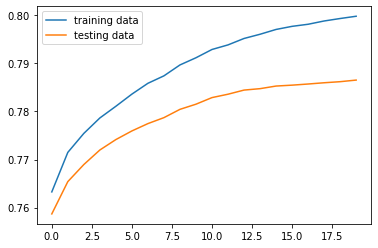

In [22]:
plt.plot(history["train"]["auc"], label="training data")
plt.plot(history["test"]["auc"], label="testing data")
#plt.yscale('symlog')
plt.legend()
plt.savefig('iteration_NLO.pdf')

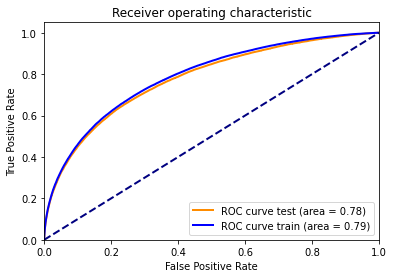

In [23]:
df_train = df_a.query('test==False')
df_test = df_a.query('test==True')
fpr_test, tpr_test,roc_auc_test=get_roc(df_test,'score_NLO')
fpr_train, tpr_train,roc_auc_train=get_roc(df_train,'score_NLO')
plt.figure()
lw = 2
plt.plot(fpr_test, tpr_test, color='darkorange',lw=lw, label='ROC curve test (area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='blue',lw=lw, label='ROC curve train (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('ROC_NLO.pdf')

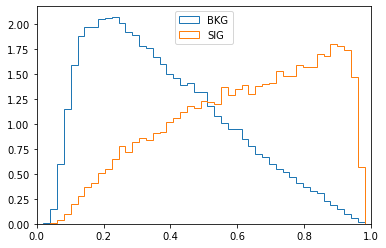

In [25]:
dtest=xgb.DMatrix(df_test[features])
y=pd.DataFrame(df_test['isSignal'],columns=['isSignal'])
y['score_NLO']=model.predict(dtest)

plt.hist(y.query('isSignal==0')['score_NLO'],label = "BKG",histtype="step",bins = np.linspace(0,1),density=True,weights=df_test.query('isSignal==0')['scalef']*df_test.query('isSignal==0')['vjj_photon_effWgt']*59.7)
plt.hist(y.query('isSignal==1')['score_NLO'],label = "SIG",histtype="step",bins = np.linspace(0,1),density=True,weights=df_test.query('isSignal==1')['scalef']*df_test.query('isSignal==1')['vjj_photon_effWgt']*59.7)
plt.legend(loc='upper center')
plt.xlim(0,1)
plt.savefig('separation_NLO.pdf')

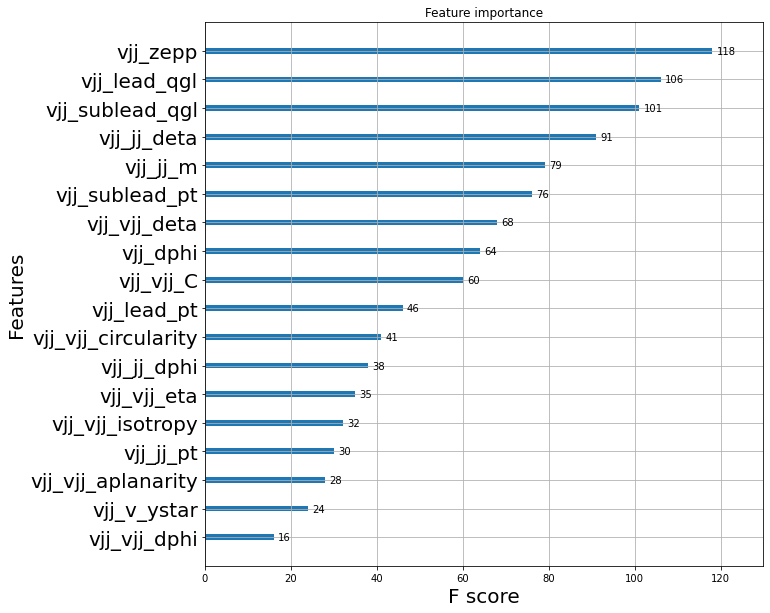

In [26]:
from xgboost import plot_importance
plt.figure(figsize = (10,10))
ax = plt.subplot()
plot_importance(model,ax=ax)
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.yaxis.set_tick_params(labelsize=20)
plt.savefig('Feature_importance_NLO.pdf',bbox_inches='tight')

In [27]:
import seaborn as sns
corr = df[features].corr()
high_corr_var=np.where(corr>0.9)
high_corr_var=[(corr.columns[x],corr.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
print(high_corr_var)

[]


In [28]:
dsig=xgb.DMatrix(sig[features])
dbkg=xgb.DMatrix(bkg[features])
sig['score_NLO']=model.predict(dsig)
bkg['score_NLO']=model.predict(dbkg)

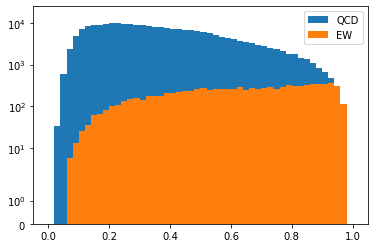

In [29]:
ax = plt.subplot(111)
plt.yscale('symlog')
ax.hist(bkg['score_NLO'],stacked=True,label="QCD",density=False,bins=np.linspace(-0,1,50+1),weights=bkg['scalef']*bkg['vjj_photon_effWgt']*59.7)
ax.hist(sig['score_NLO'],stacked=True,label="EW",density=False,bins=np.linspace(-0,1,50+1),weights=sig['scalef']*sig['vjj_photon_effWgt']*59.7)
plt.legend()
plt.ylim(0,2.5e4)
#plt.xlim(0.5,1.0)
plt.savefig('sig_bkg_distribution_NLO.pdf')

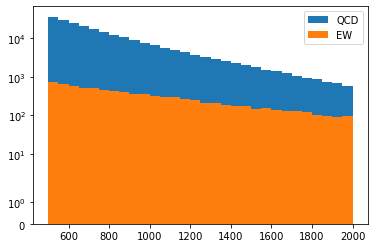

In [30]:
ax = plt.subplot(111)
plt.yscale('symlog')

ax.hist(bkg['vjj_jj_m'],stacked=True,label="QCD",bins=np.linspace(500,2e3,30+1),density=False,weights=bkg['scalef']*bkg['vjj_photon_effWgt']*59.7)
ax.hist(sig['vjj_jj_m'],stacked=True,label="EW",bins=np.linspace(500,2e3,30+1),density=False,weights=sig['scalef']*sig['vjj_photon_effWgt']*59.7)
plt.legend()
plt.savefig('mjj_NLO.pdf')

In [31]:
signal_LO = uproot.lazy(root_sig[0]+':Events')[necessary_columns]
sig_LO=pd.DataFrame(signal_LO[necessary_columns].to_numpy()).query("vjj_isGood==1 & vjj_jj_m>500 & vjj_v_pt>200 & vjj_lead_pt>50 & vjj_sublead_pt>50 & vjj_trig>0")

In [32]:
sig_LO['vjj_zepp']=abs(sig_LO['vjj_v_eta']-(sig_LO['vjj_lead_eta']+sig_LO['vjj_sublead_eta'])/2)    
sig_LO['vjj_dphi']=abs(sig_LO['vjj_v_phi']-sig_LO['vjj_jj_phi'])
sig_LO.loc[sig_LO.query('vjj_dphi>3.14').index,'vjj_dphi']=2*3.14-sig_LO.query('vjj_dphi>3.14')['vjj_dphi']

In [33]:
background_LO = uproot.lazy(root_bkg[0]+':Events')[necessary_columns]
bkg_LO=pd.DataFrame(background_LO[necessary_columns].to_numpy()).query("vjj_isGood==1 & vjj_jj_m>500 & vjj_v_pt>200 & vjj_lead_pt>50 & vjj_sublead_pt>50 & vjj_trig>0")
bkg_LO['vjj_zepp']=abs(bkg_LO['vjj_v_eta']-(bkg_LO['vjj_lead_eta']+bkg_LO['vjj_sublead_eta'])/2)    
bkg_LO['vjj_dphi']=abs(bkg_LO['vjj_v_phi']-bkg_LO['vjj_jj_phi'])
bkg_LO.loc[bkg_LO.query('vjj_dphi>3.14').index,'vjj_dphi']=2*3.14-bkg_LO.query('vjj_dphi>3.14')['vjj_dphi']

In [34]:
model1=xgb.Booster()
model1.load_model('./ajj_bdt_train_NLO.json')
dsig_LO=xgb.DMatrix(sig_LO[features])
sig_LO['score_NLO']=model1.predict(dsig_LO)

In [35]:
dbkg_LO=xgb.DMatrix(bkg_LO[features])
bkg_LO['score_NLO']=model1.predict(dbkg_LO)

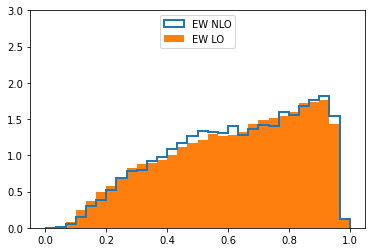

In [62]:
ax = plt.subplot(111)
#plt.yscale('symlog')

ax.hist(sig['score_NLO'],histtype="step",label="EW NLO",bins=np.linspace(0,1,30+1),density=True,linewidth=2,weights=sig['scalef']*sig['vjj_photon_effWgt'])
ax.hist(sig_LO['score_NLO'],label="EW LO",bins=np.linspace(0,1,30+1),density=True,weights=sig_LO['scalef']*sig_LO['vjj_photon_effWgt'])
#ax.hist(bkg['score_NLO'],histtype="step",label="QCD NLO",bins=np.linspace(0,1,30+1),density=True,linewidth=2)
#ax.hist(bkg_LO['score_NLO'],label="QCD LO",bins=np.linspace(0,1,30+1),density=True)
plt.legend(loc='upper center')
plt.ylim(0,3)
plt.savefig('sig_NLO_train_in_LO.pdf')

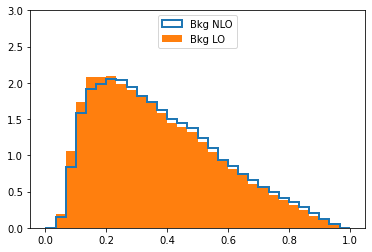

In [64]:
ax = plt.subplot(111)
#plt.yscale('symlog')

ax.hist(bkg['score_NLO'],histtype="step",label="Bkg NLO",bins=np.linspace(0,1,30+1),density=True,linewidth=2,weights=bkg['scalef']*bkg['vjj_photon_effWgt'])
ax.hist(bkg_LO['score_NLO'],label="Bkg LO",bins=np.linspace(0,1,30+1),density=True,weights=bkg_LO['scalef']*bkg_LO['vjj_photon_effWgt'])
#ax.hist(bkg['score_NLO'],histtype="step",label="QCD NLO",bins=np.linspace(0,1,30+1),density=True,linewidth=2)
#ax.hist(bkg_LO['score_NLO'],label="QCD LO",bins=np.linspace(0,1,30+1),density=True)
plt.legend(loc='upper center')
plt.ylim(0,3)
plt.savefig('bkg_NLO_train_in_LO.pdf')

In [51]:
sig_LO['isSignal']=1
bkg_LO['isSignal']=0
df_LO = pd.concat([sig_LO,bkg_LO],ignore_index=True)
print('combine the LO signal and background') 

combine the LO signal and background


In [39]:
model_LO,df_LO_a,history_LO=train_bdt(df_LO,features,"LO",xgboost_params,n_boost_rounds = 20)

88.371 4240.398
start the training
[0]	train-auc:0.7858	test-auc:0.781511
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 10 rounds.
[1]	train-auc:0.799401	test-auc:0.793306
[2]	train-auc:0.805413	test-auc:0.798282
[3]	train-auc:0.810164	test-auc:0.802404
[4]	train-auc:0.813643	test-auc:0.805453
[5]	train-auc:0.816302	test-auc:0.807645
[6]	train-auc:0.818924	test-auc:0.809284
[7]	train-auc:0.820495	test-auc:0.810345
[8]	train-auc:0.822664	test-auc:0.811857
[9]	train-auc:0.824378	test-auc:0.812759
[10]	train-auc:0.825664	test-auc:0.813383
[11]	train-auc:0.827234	test-auc:0.814572
[12]	train-auc:0.828142	test-auc:0.815094
[13]	train-auc:0.828743	test-auc:0.815394
[14]	train-auc:0.829845	test-auc:0.816134
[15]	train-auc:0.830384	test-auc:0.8163
[16]	train-auc:0.830938	test-auc:0.816419
[17]	train-auc:0.831999	test-auc:0.816938
[18]	train-auc:0.832867	test-auc:0.817205
[19]	train-auc:0.833514	test-auc:0.81743

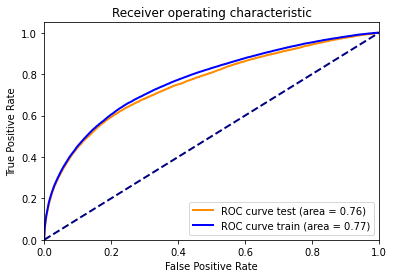

In [53]:
df_trainLO = df_LO_a.query('test==False')
df_testLO = df_LO_a.query('test==True')
fpr_testLO, tpr_testLO,roc_auc_testLO=get_roc(df_testLO,'score_LO')
fpr_trainLO, tpr_trainLO,roc_auc_trainLO=get_roc(df_trainLO,'score_LO')
plt.figure()
lw = 2
plt.plot(fpr_testLO, tpr_testLO, color='darkorange',lw=lw, label='ROC curve test (area = %0.2f)' % roc_auc_testLO)
plt.plot(fpr_trainLO, tpr_trainLO, color='blue',lw=lw, label='ROC curve train (area = %0.2f)' % roc_auc_trainLO)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('ROC_LO.pdf')

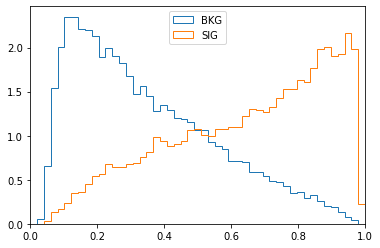

In [54]:
dtestLO=xgb.DMatrix(df_testLO[features])
y=pd.DataFrame(df_testLO['isSignal'],columns=['isSignal'])
y['score_LO']=model_LO.predict(dtestLO)

plt.hist(y.query('isSignal==0')['score_LO'],label = "BKG",histtype="step",bins = np.linspace(0,1),density=True,weights=df_testLO.query('isSignal==0')['scalef'])
plt.hist(y.query('isSignal==1')['score_LO'],label = "SIG",histtype="step",bins = np.linspace(0,1),density=True,weights=df_testLO.query('isSignal==1')['scalef'])
plt.legend(loc='upper center')
plt.xlim(0,1)
plt.savefig('separation_LO.pdf')

NameError: name 'model_LO' is not defined

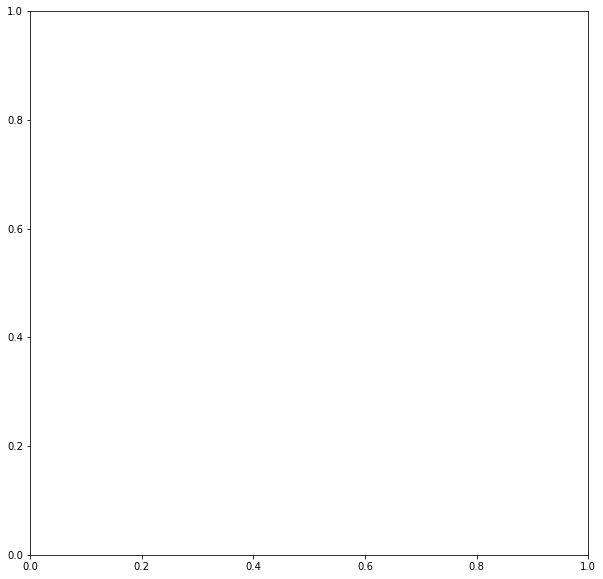

In [6]:
from xgboost import plot_importance
plt.figure(figsize = (10,10))
ax = plt.subplot()
plot_importance(model_LO,ax=ax)
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.yaxis.set_tick_params(llabelsize=20)
plt.savefig('Feature_importance_LO.pdf',bbox_inches='tight')

In [56]:
sig['score_LO']=model_LO.predict(dsig)
bkg['score_LO']=model_LO.predict(dbkg)

In [57]:
sig_LO['score_LO']=model_LO.predict(dsig_LO)
bkg_LO['score_LO']=model_LO.predict(dbkg_LO)

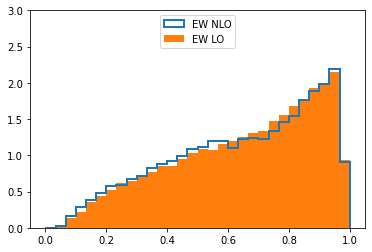

In [66]:
ax = plt.subplot(111)
#plt.yscale('symlog')

ax.hist(sig['score_LO'],histtype="step",label="EW NLO",bins=np.linspace(0,1,30+1),density=True,linewidth=2,weights=sig['scalef']*sig['vjj_photon_effWgt'])
ax.hist(sig_LO['score_LO'],label="EW LO",bins=np.linspace(0,1,30+1),density=True,weights=sig_LO['scalef']*sig_LO['vjj_photon_effWgt'])
#ax.hist(bkg['score_LO'],histtype="step",label="QCD NLO",bins=np.linspace(0,1,30+1),density=True,linewidth=2)
#ax.hist(bkg_LO['score_LO'],label="QCD LO",bins=np.linspace(0,1,30+1),density=True)
plt.legend(loc='upper center')
plt.ylim(0,3)
plt.savefig('sig_LO_train_in_NLO.pdf')

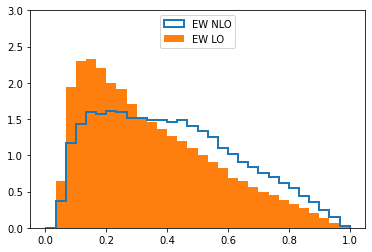

In [67]:
ax = plt.subplot(111)
#plt.yscale('symlog')

ax.hist(bkg['score_LO'],histtype="step",label="EW NLO",bins=np.linspace(0,1,30+1),density=True,linewidth=2,weights=bkg['scalef']*bkg['vjj_photon_effWgt'])
ax.hist(bkg_LO['score_LO'],label="EW LO",bins=np.linspace(0,1,30+1),density=True,weights=bkg_LO['scalef']*bkg_LO['vjj_photon_effWgt'])
#ax.hist(bkg['score_LO'],histtype="step",label="QCD NLO",bins=np.linspace(0,1,30+1),density=True,linewidth=2)
#ax.hist(bkg_LO['score_LO'],label="QCD LO",bins=np.linspace(0,1,30+1),density=True)
plt.legend(loc='upper center')
plt.ylim(0,3)
plt.savefig('bkg_LO_train_in_NLO.pdf')


(0.0, 3.0)

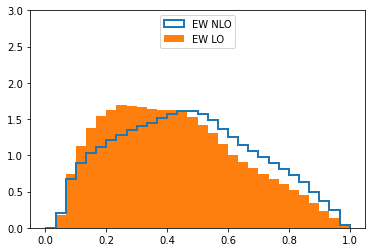

In [69]:
ax = plt.subplot(111)
#plt.yscale('symlog')

ax.hist(bkg['score_LO'],histtype="step",label="EW NLO",bins=np.linspace(0,1,30+1),density=True,linewidth=2)
ax.hist(bkg_LO['score_LO'],label="EW LO",bins=np.linspace(0,1,30+1),density=True)
#ax.hist(bkg['score_LO'],histtype="step",label="QCD NLO",bins=np.linspace(0,1,30+1),density=True,linewidth=2)
#ax.hist(bkg_LO['score_LO'],label="QCD LO",bins=np.linspace(0,1,30+1),density=True)
plt.legend(loc='upper center')
plt.ylim(0,3)
#plt.savefig('bkg_LO_train_in_NLO.pdf')


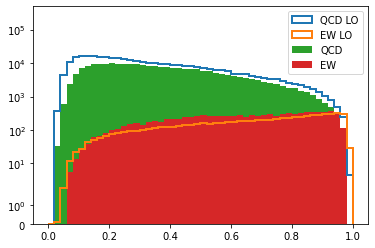

In [68]:
ax = plt.subplot(111)
plt.yscale('symlog')
ax.hist(bkg_LO['score_LO'],histtype="step",stacked=True,label="QCD LO",density=False,bins=np.linspace(-0,1,50+1),weights=bkg_LO['scalef']*bkg_LO['vjj_photon_effWgt']*59.7,linewidth=2)
ax.hist(sig_LO['score_LO'],histtype="step",stacked=True,label="EW LO",density=False,bins=np.linspace(-0,1,50+1),weights=sig_LO['scalef']*sig_LO['vjj_photon_effWgt']*59.7,linewidth=2)
ax.hist(bkg['score_NLO'],stacked=True,label="QCD",density=False,bins=np.linspace(-0,1,50+1),weights=bkg['scalef']*bkg['vjj_photon_effWgt']*59.7)
ax.hist(sig['score_NLO'],stacked=True,label="EW",density=False,bins=np.linspace(-0,1,50+1),weights=sig['scalef']*sig['vjj_photon_effWgt']*59.7)
plt.legend()
plt.ylim(0,50e4)
#plt.xlim(0,1.0)
plt.savefig('sig_bkg_distribution.pdf')

In [7]:
model1=xgb.Booster()
model1.load_model('./ajj_train_test.json')

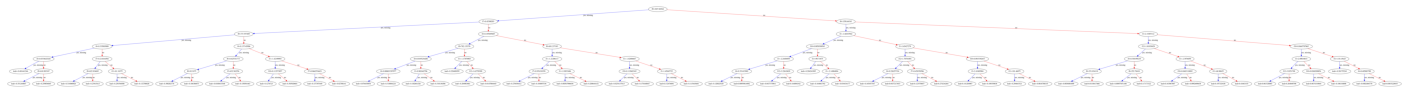

<Figure size 432x288 with 0 Axes>

In [23]:
fig, ax = plt.subplots(figsize = (25, 10))
xgb.plot_tree(model1, ax = ax)
plt.show()
plt.savefig('visulization.pdf')

In [11]:
import graphviz
graphviz.__file__

'/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/graphviz/__init__.py'